https://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
import my_utils as utl
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train/255 , x_test/255
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, shuffle=True)
#y_train = tf.one_hot(y_train.astype(np.int32), depth=10)

In [ ]:
# show image
#img = Image.fromarray(x_train[1], 'RGB')
#img.show()
# transform to gray np.dot(x_train[1], [0.2989, 0.5870, 0.1140])

plt.imshow(x_train[0], cmap='gray')
plt.show()

In [4]:
print(28*28)
print(x_train.shape)
y_train.shape

784
(51000, 28, 28)


(51000,)

In [22]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(28,28)),
        tf.keras.layers.Dense(60, activation="relu", name="layer1"),
        tf.keras.layers.Dense(60, activation="relu", name="layer2"),
        tf.keras.layers.Dense(10, activation="softmax", name="output_layer"),
    ]
)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
EarlyStopping_callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
ModelCheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="checkpoint", save_best_only=True)
TensorBoard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")
model_history = model.fit(x=x_train, y=y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val), callbacks=[EarlyStopping_callback, ModelCheckpoint_callback, TensorBoard_callback])

Epoch 1/50
1552/1594 [============================>.] - ETA: 0s - loss: 0.5627 - accuracy: 0.8067

INFO:tensorflow:Assets written to: checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\assets


1594/1594 [==============================] - 2s 1ms/step - loss: 0.5602 - accuracy: 0.8073 - val_loss: 0.4354 - val_accuracy: 0.8453
Epoch 2/50
1543/1594 [============================>.] - ETA: 0s - loss: 0.4132 - accuracy: 0.8511

INFO:tensorflow:Assets written to: checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\assets


1594/1594 [==============================] - 2s 1ms/step - loss: 0.4121 - accuracy: 0.8515 - val_loss: 0.3813 - val_accuracy: 0.8611
Epoch 3/50
1594/1594 [==============================] - 2s 956us/step - loss: 0.3761 - accuracy: 0.8639 - val_loss: 0.3917 - val_accuracy: 0.8622
Epoch 4/50
1558/1594 [============================>.] - ETA: 0s - loss: 0.3568 - accuracy: 0.8709

INFO:tensorflow:Assets written to: checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\assets


1594/1594 [==============================] - 2s 1ms/step - loss: 0.3563 - accuracy: 0.8712 - val_loss: 0.3558 - val_accuracy: 0.8694
Epoch 5/50
1594/1594 [==============================] - 2s 949us/step - loss: 0.3452 - accuracy: 0.8753 - val_loss: 0.3586 - val_accuracy: 0.8677
Epoch 6/50
1594/1594 [==============================] - 2s 990us/step - loss: 0.3344 - accuracy: 0.8796 - val_loss: 0.3795 - val_accuracy: 0.8676
Epoch 7/50
1594/1594 [==============================] - 2s 945us/step - loss: 0.3246 - accuracy: 0.8825 - val_loss: 0.3897 - val_accuracy: 0.8636
Epoch 8/50
1594/1594 [==============================] - 2s 941us/step - loss: 0.3176 - accuracy: 0.8858 - val_loss: 0.4528 - val_accuracy: 0.8613
Epoch 9/50
1594/1594 [==============================] - 2s 953us/step - loss: 0.3132 - accuracy: 0.8865 - val_loss: 0.3619 - val_accuracy: 0.8761
Epoch 10/50
1594/1594 [==============================] - 2s 973us/step - loss: 0.3088 - accuracy: 0.8895 - val_loss: 0.3752 - val_accurac

In [ ]:
# tensorboard
%load_ext tensorboard
%tensorboard --logdir=./logs #--port=8877

In [23]:
model.evaluate(x=x_test, y=y_test, verbose=1)

313/313 [==============================] - 0s 631us/step - loss: 0.3918 - accuracy: 0.8624


[0.3917652666568756, 0.8623999953269958]

In [16]:
pred = model.predict(x_test)

313/313 [==============================] - 0s 549us/step


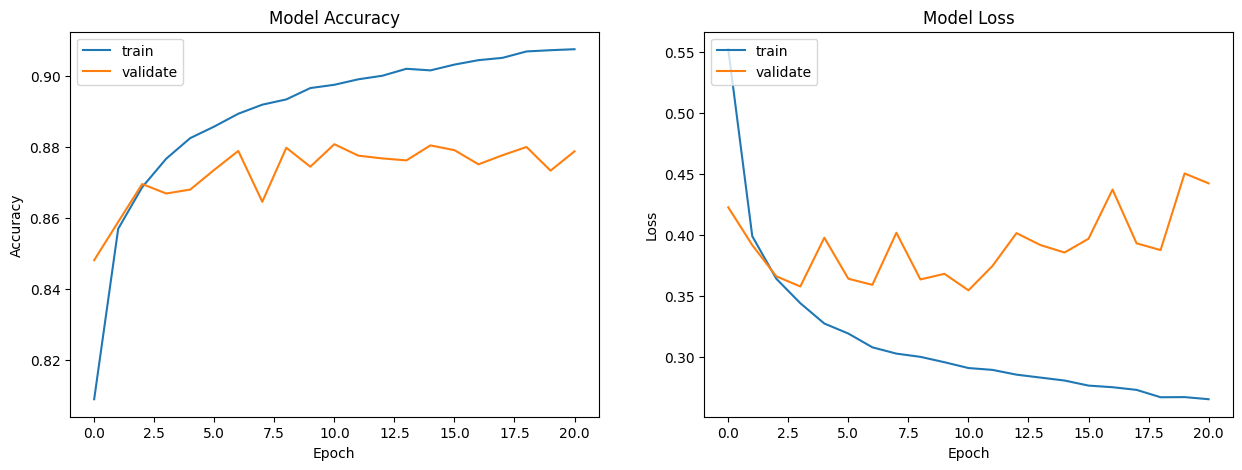

In [21]:
utl.plot_model_history(model_history)

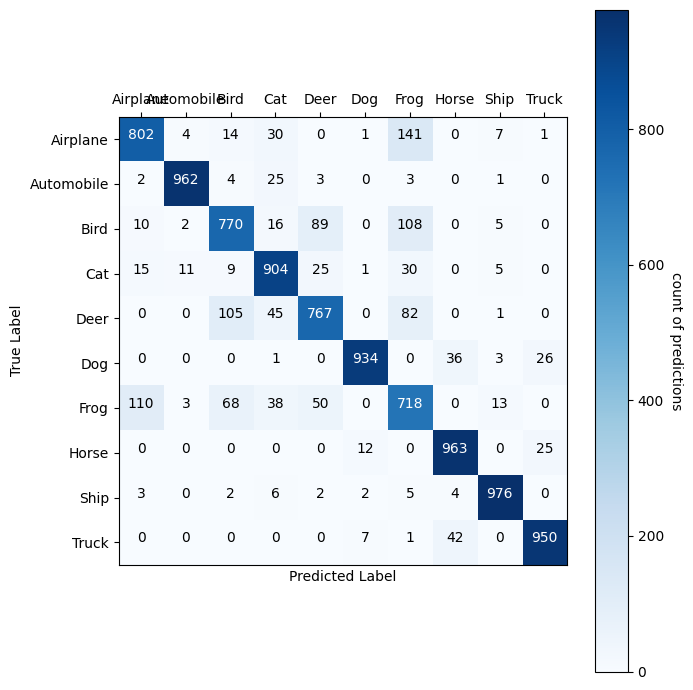

In [18]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
Y_pred_classes = np.argmax(pred, axis=1) 
Y_true = y_test
errors = (Y_pred_classes - Y_true != 0)
Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = x_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes) 
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(7,7))
im, cbar = utl.heatmap(cm, labels, labels, ax=ax,cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = utl.annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()

In [12]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1000
           1       1.00      0.96      0.98      1000
           2       0.83      0.71      0.76      1000
           3       0.82      0.93      0.87      1000
           4       0.78      0.80      0.79      1000
           5       0.97      0.96      0.96      1000
           6       0.66      0.68      0.67      1000
           7       0.86      0.97      0.91      1000
           8       0.96      0.97      0.97      1000
           9       0.97      0.86      0.91      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



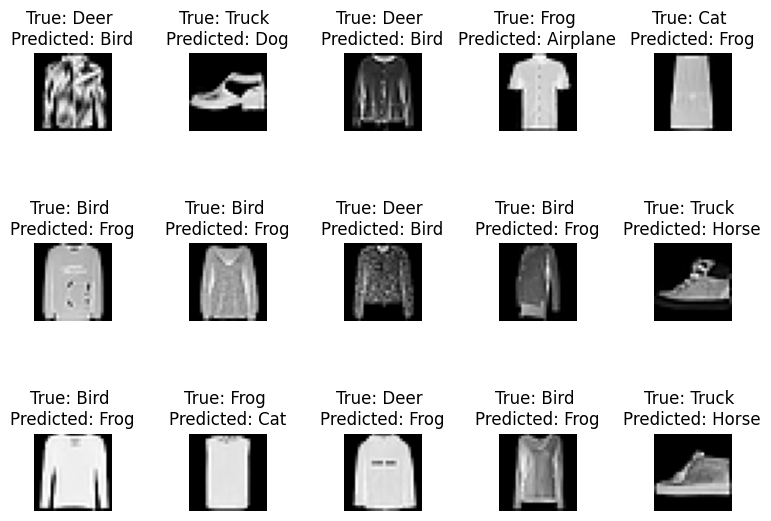

In [13]:
utl.error_imshow(Y_true, Y_pred_classes, x_test, labels)

In [25]:
model.save("fashion_mnist.h5")
#tf.keras.models.load_model("fashion_mnist.h5")